<a href="https://colab.research.google.com/github/alitootoonchian/FinTech/blob/master/StockPredLTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime as dt
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas_datareader.data  as pdr
from tqdm.auto import tqdm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]


In [0]:
training_days = 30
total_years = 15
total_dates = total_years * 365

In [0]:
ticker = 'AAPL'
valid_set_size_percentage = 20
test_set_size_percentage = 10
seq_len = training_days
stocks = pdr.get_data_yahoo(ticker, dt.date.today() - dt.timedelta(total_dates), dt.date.today())

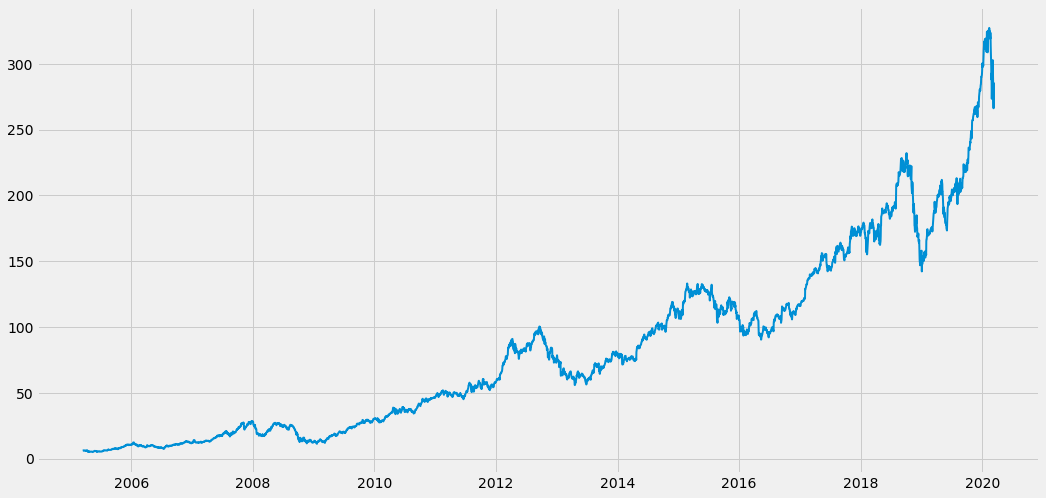

,high,low,open,close,volume,adj close
Date,,,,,,
2005-03-15,5.877143,5.750000,5.805714,5.851429,127152200.0,5.079279
2005-03-16,6.044286,5.825714,5.887143,5.882857,174453300.0,5.106561
2005-03-17,6.125714,5.902857,5.932857,6.035714,200480000.0,5.239247
2005-03-18,6.205714,6.071429,6.190000,6.137143,235037600.0,5.327291
2005-03-21,6.281428,6.122857,6.184286,6.242857,135282000.0,5.419054
2005-03-22,6.280000,6.097143,6.244286,6.118571,137853800.0,5.311170
2005-03-23,6.200000,6.002857,6.064286,6.078571,152455800.0,5.276449
2005-03-24,6.142857,6.071429,6.130000,6.071429,88176200.0,5.270248
2005-03-28,6.137143,6.067143,6.107143,6.075714,68852700.0,5.273967


,high,low,open,close,volume,adj close
Date,,,,,,
2020-02-27,286.000000,272.959991,281.100006,273.519989,80151400.0,273.519989
2020-02-28,278.410004,256.369995,257.260010,273.359985,106721200.0,273.359985
2020-03-02,301.440002,277.720001,282.279999,298.809998,85349300.0,298.809998
2020-03-03,304.000000,285.799988,303.670013,289.320007,79868900.0,289.320007
2020-03-04,303.399994,293.130005,296.440002,302.739990,54794600.0,302.739990
2020-03-05,299.549988,291.410004,295.519989,292.920013,46893200.0,292.920013
2020-03-06,290.820007,281.230011,282.000000,289.029999,56544200.0,289.029999
2020-03-09,278.089996,263.000000,263.750000,266.170013,71686200.0,266.170013
2020-03-10,286.440002,269.369995,277.140015,285.339996,71184900.0,285.339996


In [5]:
stocks = stocks.rename(str.lower, axis='columns')
plt.plot(stocks['close'], linewidth=2)
plt.show()
display(stocks.head(10))
display(stocks.tail(10))

In [0]:
def add_technical_indicators(dataset, price):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = price.rolling(window=7).mean()
    dataset['ma21'] = price.rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = price.ewm(span=26, min_periods=26).mean()
    dataset['12ema'] = price.ewm(span=12, min_periods=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = price.rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = price.ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = price - 1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    dataset.dropna(inplace=True)
    
    return dataset

In [7]:
add_technical_indicators(stocks, stocks.close)
stocks.dropna(inplace=True)
stocks["target"] = stocks['adj close'].shift(-2)
stocks["dir"] = (stocks['adj close'].shift(-2) - stocks['adj close']) / stocks['adj close']
stocks['buy'] = (stocks.dir > 0.02).astype(np.int)
stocks['sell'] = (stocks.dir < -0.02).astype(np.int)
stocks['signal'] = stocks.buy + stocks.sell * -1
stocks.dropna(inplace=True)
stocks.drop(columns=['adj close', 'target', 'dir', 'buy', 'sell'], axis=1, inplace=True)
display(stocks)

,high,low,open,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,signal
Date,,,,,,,,,,,,,,,,,
2005-04-20,5.391428,5.062857,5.380000,5.072857,236282900.0,5.398572,5.827075,5.711464,5.530237,-0.181226,0.401153,6.629382,5.024768,5.129228,4.072857,1.404345,0
2005-04-21,5.315714,5.128572,5.200000,5.311429,189898100.0,5.286735,5.788640,5.677591,5.496200,-0.181391,0.410930,6.610500,4.966779,5.250695,4.311429,1.461269,0
2005-04-22,5.285714,4.985714,5.262857,5.071429,209782300.0,5.173674,5.740680,5.626803,5.430237,-0.196566,0.433094,6.606869,4.874492,5.131184,4.071429,1.403994,0
2005-04-25,5.288571,5.158571,5.212857,5.282857,186615100.0,5.167959,5.703129,5.598262,5.407383,-0.190879,0.435500,6.574129,4.832130,5.232299,4.282857,1.454620,-1
2005-04-26,5.358572,5.160000,5.254286,5.170000,202626900.0,5.185102,5.660000,5.563039,5.370618,-0.192421,0.444760,6.549521,4.770479,5.190767,4.170000,1.427916,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-03,304.000000,285.799988,303.670013,289.320007,79868900.0,287.702850,309.631901,304.115250,297.513902,-6.601348,17.821958,345.275817,273.987986,289.900733,288.320007,5.664071,0
2020-03-04,303.399994,293.130005,296.440002,302.739990,54794600.0,288.354279,309.349996,304.013379,298.317916,-5.695463,17.749626,344.849249,273.850743,298.460238,301.739990,5.709566,-1
2020-03-05,299.549988,291.410004,295.519989,292.920013,46893200.0,289.045711,308.115234,303.191648,297.487469,-5.704179,17.832064,343.779363,272.451106,294.766755,291.920013,5.676480,-1


In [0]:
class StockModel:
    def __init__(self, stocks, training_days):
        self.features = stocks.columns
        self.stocks = stocks.copy()
        self.stocks_scaled = stocks.copy()
        self.seq = training_days
        self.index_in_epoch = 0
        self.close_scaler = None

    def normalize_data(self):
        for feature in self.features:
            if feature != 'signal':
                min_max_scaler = sklearn.preprocessing.MinMaxScaler()
                self.stocks_scaled[feature] = min_max_scaler.fit_transform(self.stocks[feature].values.reshape(-1, 1))
                if (feature == 'close'):
                    self.close_scaler = min_max_scaler
        self.stocks_scaled = self.stocks_scaled[self.features]
        display(self.stocks_scaled.head(5))

    def load_data(self):
        data_raw = self.stocks_scaled.values
        data = []
        for index in range(len(data_raw) - self.seq):
            data.append(data_raw[index: index + self.seq])
        data = np.array(data)
        valid_size = int(valid_set_size_percentage/100*data.shape[0])
        test_size = int(test_set_size_percentage/100*data.shape[0])
        train_size = len(data) - valid_size - test_size
        self.x_train = data[:train_size, :-1, :-1]
        self.y_train = data[:train_size,  -1, -1:]
        
        self.x_valid = data[train_size: train_size + valid_size, :-1, :-1]
        self.y_valid = data[train_size: train_size + valid_size,  -1, -1:]
        
        self.x_test  = data[train_size + valid_size:, :-1, :-1]
        self.y_test  = data[train_size + valid_size:,  -1, -1:]

        self.perm_array = np.arange(self.x_train.shape[0])
        np.random.shuffle(self.perm_array)

        print ('x_train.shape:', self.x_train.shape)
        print ('y_train.shape:', self.y_train.shape)
        print ('x_valid.shape:', self.x_valid.shape)
        print ('y_valid.shape:', self.y_valid.shape)
        print (' x_test.shape:', self.x_test.shape)
        print (' y_test.shape:', self.y_test.shape)
        print(self.y_test[-3:, 0])

    def get_next_batch(self, batch_size):
        start = self.index_in_epoch
        self.index_in_epoch += batch_size
        if self.index_in_epoch > self.x_train.shape[0]:
            np.random.shuffle(self.perm_array)
        start = 0
        self.index_in_epoch += batch_size
        end = self.index_in_epoch
        return self.x_train[self.perm_array[start:end]], self.y_train[self.perm_array[start:end]]

    def train_predict(self):
        self.index_in_epoch = 0
        n_steps = self.seq - 1
        n_inputs = self.x_test.shape[2]
        n_neurons = 200
        n_outputs = 1
        n_layers = 2
        learining_rate = 0.001
        batch_size = 50
        n_epoch = 50
        train_set_size = self.x_train.shape[0]
        test_set_size = self.x_test.shape[0]
        tf.reset_default_graph()
        X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
        y = tf.placeholder(tf.float32, [None, n_outputs])

        #RNN
        layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu) for layer in range(n_layers)]

        multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
        rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
        stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
        stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
        outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
        outputs = outputs[:,n_steps - 1,:]

        loss = tf.reduce_mean(tf.square(outputs - y))
        optimizer = tf.train.AdamOptimizer(learning_rate=learining_rate)
        training_op = optimizer.minimize(loss)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for iteration in range(int(n_epoch*train_set_size/batch_size)):
                x_batch, y_batch = self.get_next_batch(batch_size)
                sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
                if iteration % int(5*train_set_size/batch_size) == 0:
                    mse_train = loss.eval(feed_dict={X: self.x_train, y: self.y_train})
                    mse_valid = loss.eval(feed_dict={X: self.x_valid, y: self.y_valid})
                    print ('%5.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))
            #y_test_pred = sess.run(outputs, feed_dict={X: x_test})
            pred = sess.run(outputs, feed_dict={X: self.x_test})
        return pred[:,0]

In [9]:
model = StockModel(stocks, training_days)
model.normalize_data()
model.load_data()
pred = model.train_predict()

,high,low,open,close,volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,signal
Date,,,,,,,,,,,,,,,,,
2005-04-20,0.001111,0.001045,0.001545,0.000612,0.270376,0.001080,0.002147,0.001507,0.001294,0.484126,0.015680,0.003644,0.001427,0.000522,0.000612,0.011193,0
2005-04-21,0.000876,0.001251,0.000983,0.001352,0.214618,0.000729,0.002025,0.001398,0.001186,0.484119,0.016184,0.003588,0.001237,0.000902,0.001352,0.024034,0
2005-04-22,0.000783,0.000803,0.001179,0.000607,0.238520,0.000374,0.001873,0.001235,0.000977,0.483443,0.017328,0.003578,0.000934,0.000528,0.000607,0.011114,0
2005-04-25,0.000792,0.001345,0.001023,0.001263,0.210671,0.000356,0.001753,0.001143,0.000905,0.483696,0.017452,0.003482,0.000794,0.000844,0.001263,0.022534,-1
2005-04-26,0.001009,0.001350,0.001152,0.000913,0.229919,0.000410,0.001616,0.001030,0.000789,0.483627,0.017930,0.003409,0.000592,0.000715,0.000913,0.016510,0


x_train.shape: (2603, 29, 16)
y_train.shape: (2603, 1)
x_valid.shape: (743, 29, 16)
y_valid.shape: (743, 1)
 x_test.shape: (371, 29, 16)
 y_test.shape: (371, 1)
[-1. -1.  0.]
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updat

In [10]:
result = pd.DataFrame({'signal': stocks.iloc[-pred.shape[0]:]['signal'], 
                       'predict':pred, 
                       'price':stocks.iloc[-pred.shape[0]:]['close']})
buy_sell_threshold = 0.015
result['buy'] = result.signal > buy_sell_threshold
result['sell'] = result.signal < -buy_sell_threshold
result['hold'] = (result.buy == False) & (result.sell == False)
display(result)


,signal,predict,price,buy,sell,hold
Date,,,,,,
2018-09-17,0,0.006347,217.880005,False,False,True
2018-09-18,0,-0.362026,218.240005,False,False,True
2018-09-19,0,-0.845818,218.369995,False,False,True
2018-09-20,0,-1.316233,220.029999,False,False,True
2018-09-21,1,-0.691468,217.660004,True,False,False
...,...,...,...,...,...,...
2020-03-03,0,0.623805,289.320007,False,False,True
2020-03-04,-1,-0.533523,302.739990,False,True,False
2020-03-05,-1,-2.155038,292.920013,False,True,False


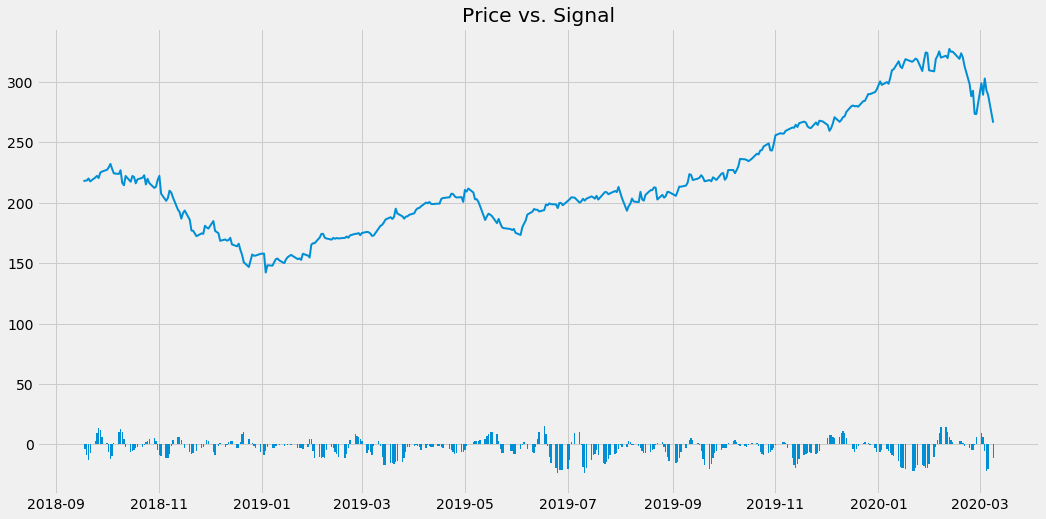

In [11]:
plt.plot(result.price, linewidth=2)
plt.bar(x=result.index, height=result.predict* 10)
plt.title("Price vs. Signal")
plt.show()

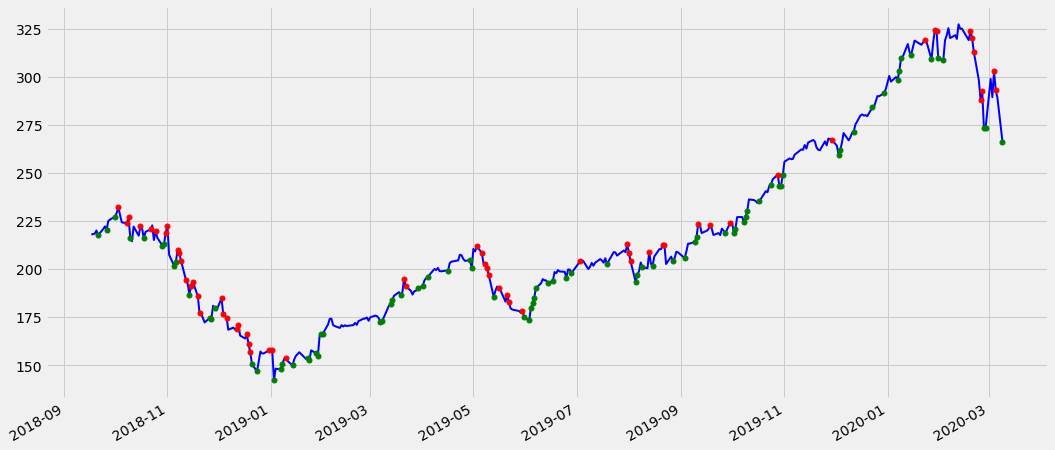

In [12]:
fig, ax1 = plt.subplots()
plt.plot(result['price'].index, result['price'], 'b-', linewidth=2) 

# Plot the buy signals
ax1.plot(result.loc[result.buy].index, result['price'][result.buy], 'o', markersize=5, color='g')

# Plot the sell signals
ax1.plot(result.loc[result.sell].index, result['price'][result.sell], 'o', markersize=5, color='r')

# Plot the hold signals
# ax1.plot(result.loc[result.hold].index, result['price'][result.hold], 'o', markersize=5, color='b')

fig.autofmt_xdate()

## Profit Calculation

In [0]:
import math

portfolio = pd.DataFrame()
portfolio['price'] = np.array(result.price)
portfolio['buy'] = np.array(result.buy.astype(np.int))
portfolio['sell'] = np.array(result.sell.astype(np.int))
portfolio['holding_stocks'] = portfolio.groupby((portfolio.sell == 1).cumsum()).buy.cumsum()
portfolio['holding_stocks_new'] = portfolio.holding_stocks * portfolio.buy
portfolio['holding_stocks_acc'] = portfolio.groupby((portfolio.sell == 1).cumsum()).holding_stocks_new.cumsum().shift(1)
portfolio['cost'] = (portfolio.buy * portfolio.price).cumsum()
portfolio['revenue'] = (portfolio.sell * portfolio.holding_stocks_acc * portfolio.price).cumsum()
portfolio['profit'] = portfolio.revenue - portfolio.cost
portfolio = portfolio.set_index(result.index)

invest = -portfolio['profit'].min()
profit = portfolio.profit[-1]
ret = profit / invest
total_dates = (portfolio.index[-1] - portfolio.index[0]).total_seconds() / (60 * 60* 24)
#display(portfolio.head(20))

Invest: 665.3399963378906
Profit: 48864.50048828125
Return: 73.44290251185438
Portofilo Dates: 539.0
Avg Daily Return:0.800


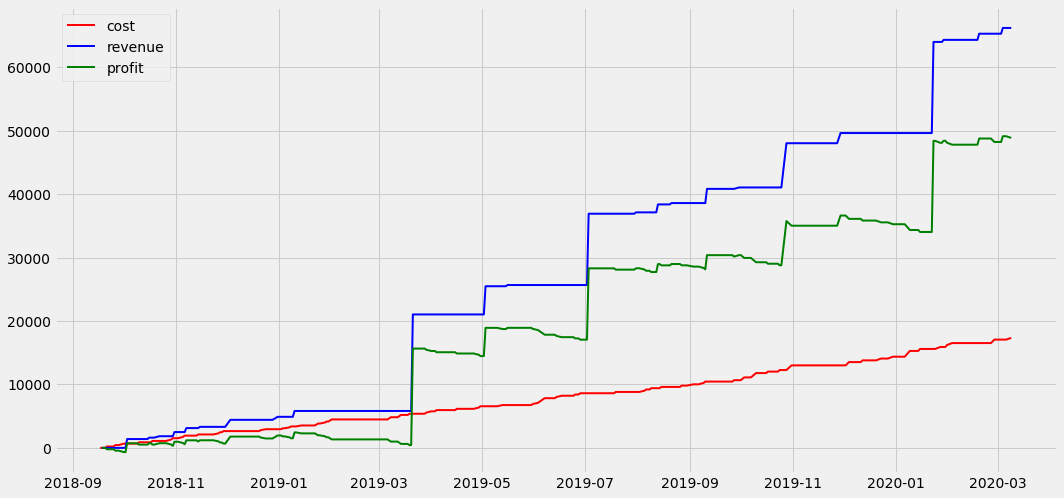

In [14]:
print("Invest:", invest)
print("Profit:", profit)
print("Return:", ret)
print("Portofilo Dates:", total_dates)
print("Avg Daily Return:%5.3f"%((np.power(ret, 1/total_dates) - 1) * 100))

plt.plot(portfolio.cost, linewidth = 2, color='r', label='cost')
plt.plot(portfolio.revenue, linewidth = 2, color='b', label='revenue')
plt.plot(portfolio.profit, linewidth = 2, color='g', label='profit')
plt.legend()
plt.show()